In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 1


In [2]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Regression', Feature_Counts=[2,2])

#Reg_Data.df().head()

[]
['Active_0', 'Active_1']
Coeffs and Order:  [37.25267479 31.91707798] [1 0]
['Active_1', 'Active_0']
[1 0]
[37.25267479 31.91707798]


In [3]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8634544821407524


MLPRegressor(random_state=RandomState(MT19937) at 0x1C8861D9840)

In [4]:
Reg_Data.Random_Forest()

0.9915392088184699


RandomForestRegressor(random_state=RandomState(MT19937) at 0x1C8861D9840)

In [5]:
Reg_Data.GP()

0.6817356538611105


GaussianProcessRegressor()

In [6]:
print(Reg_Data.get_features())

['Active_1', 'Active_0']


In [7]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [-0.02450589 -0.05335111]
Std 0:  [1.05124956 0.96269038]


In [9]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 30,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict)
    
    scores = URM_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model())


INSTANCE:  0
NEXT X:  [[-2.60452561 -0.43685138]]
NEXT X:  [[-2.60452561 -0.06487151]]
NEXT X:  [[-2.25369504 -0.30866862]]
NEXT X:  [[-0.62488752  1.37601838]]
NEXT X:  [[-0.67370313  1.33131508]]
NEXT X:  [[-2.60452561 -0.35126878]]
NEXT X:  [[-1.78077583  0.33629252]]
NEXT X:  [[-1.37595203  0.16055832]]
NEXT X:  [[-1.23217008  0.81989441]]
NEXT X:  [[-1.76266466  0.88223552]]
NEXT X:  [[-1.95966406  0.15368586]]
NEXT X:  [[-1.77174163 -0.0572232 ]]
NEXT X:  [[-0.89648951  1.12729665]]
NEXT X:  [[-1.43964678  0.62989458]]
NEXT X:  [[-1.67444796  0.26394394]]
NEXT X:  [[-1.64104474  0.4454641 ]]
NEXT X:  [[-1.05239806  0.510189  ]]
NEXT X:  [[-1.3552827   1.16916276]]
NEXT X:  [[-1.44545968  0.44124982]]
NEXT X:  [[-1.84467877  0.25898455]]
NEXT X:  [[-1.5064011   0.56876513]]
NEXT X:  [[-1.74871396  0.33381364]]
NEXT X:  [[-1.48802069  0.7778093 ]]
NEXT X:  [[-0.62866685  0.8750389 ]]
NEXT X:  [[-2.17260972 -0.04132086]]
NEXT X:  [[-2.1565458   0.51096808]]
NEXT X:  [[-1.74227365  0

In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[-37.71097345]
[-3.77109735e+01  1.00000004e-05]


In [12]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           1.1546161691736998  :  0.0  :  1.1546161691736998
y - exp(x):          1.1546161528557946  :  0.0  :  1.1546161528557946
BB(x) - exp(x):      1.6317905249252362e-08  :  0.0  :  1.6317905249252362e-08
Average exp(x) var:  1.0000000413701846e-05


In [13]:
#Reg_Stats.Jaccard_Values()

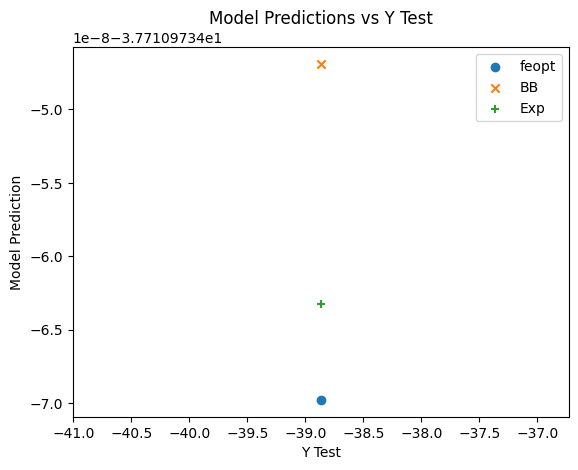

In [14]:
Reg_Stats.Reg_Fidelity_Graph()

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF

#X, y = URM_Exp.get_surrogate_data()
#kernel = Matern()

#GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer = 10, optimizer='fmin_l_bfgs_b', normalize_y = False, copy_X_train=True)
#GP.fit(X, y)
        
#print(y[0])
#fe = GP.predict(X[0].reshape(1,-1))
#print(fe)
#ey = URM_Exp.gpmodel_predict(X[0].reshape(1,-1))
#print(ey)


In [16]:
acq_data.Create_BB_plot()

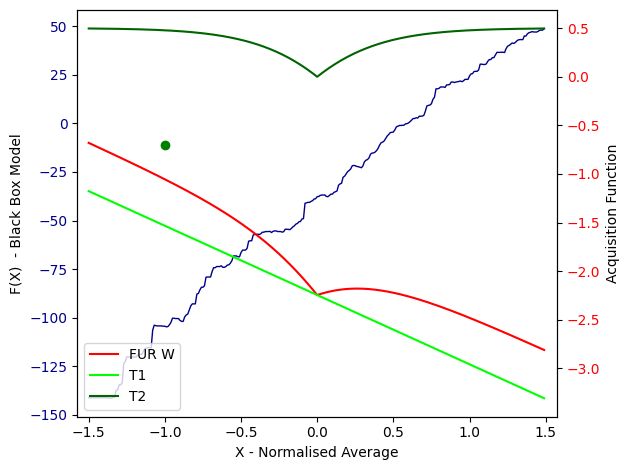

In [17]:
acq_data.plot_point(0)

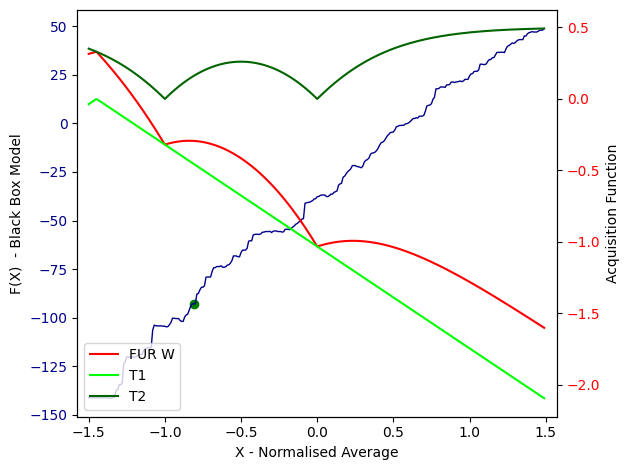

In [18]:
acq_data.plot_point(1)

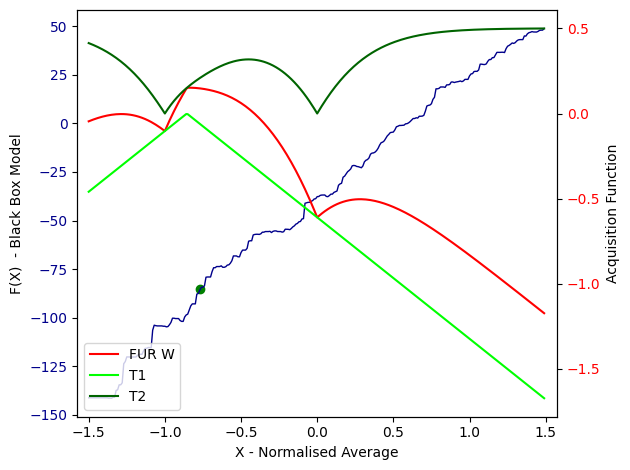

In [19]:
acq_data.plot_point(2)

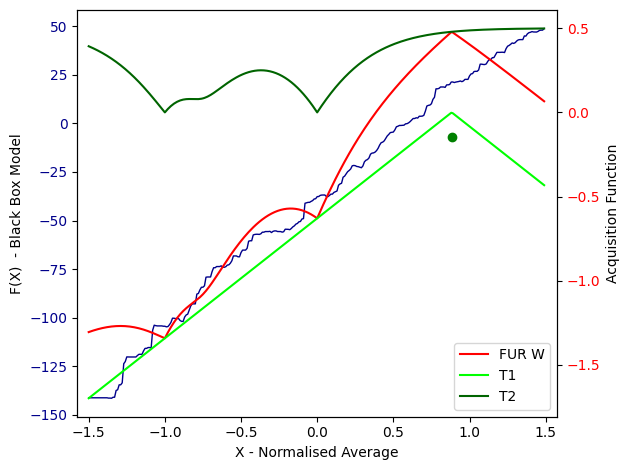

In [20]:
acq_data.plot_point(3)

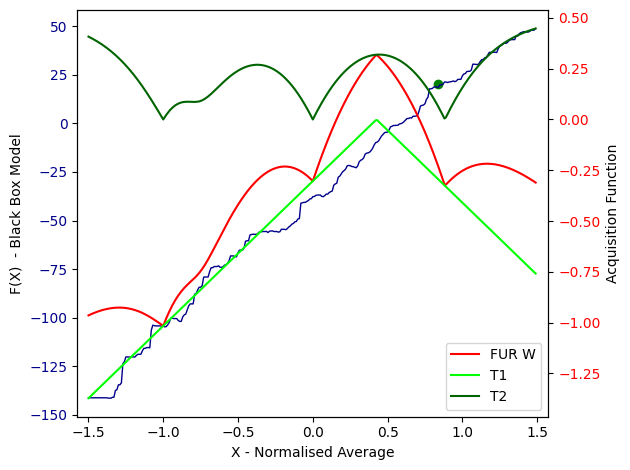

In [21]:
acq_data.plot_point(4)

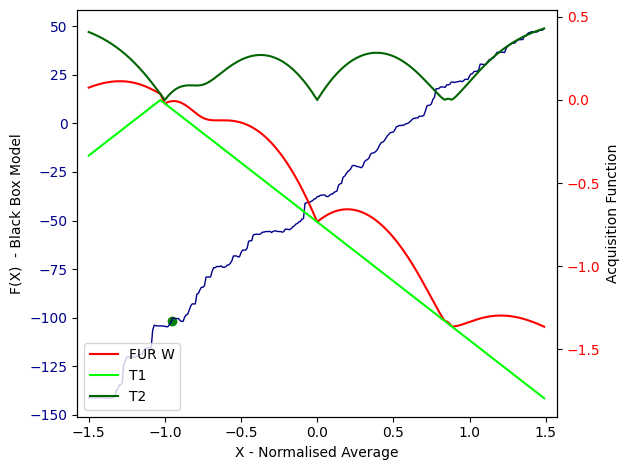

In [22]:
acq_data.plot_point(5)

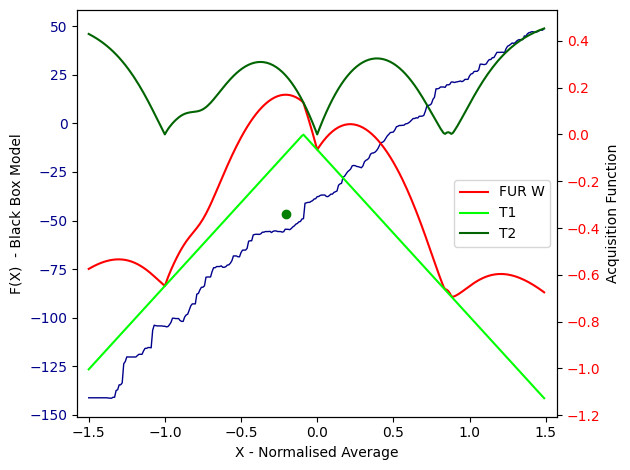

In [23]:
acq_data.plot_point(6)

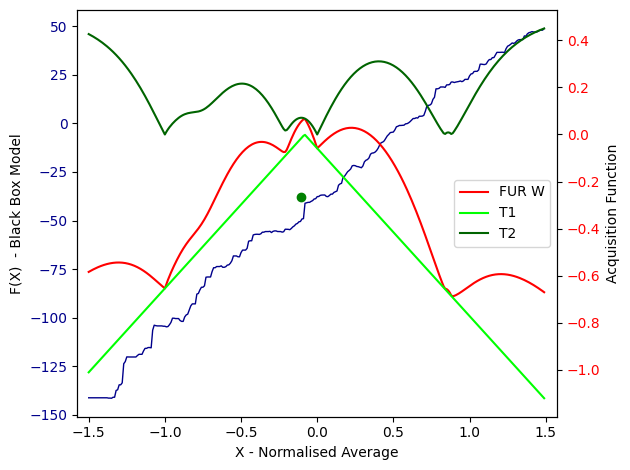

In [24]:
acq_data.plot_point(7)

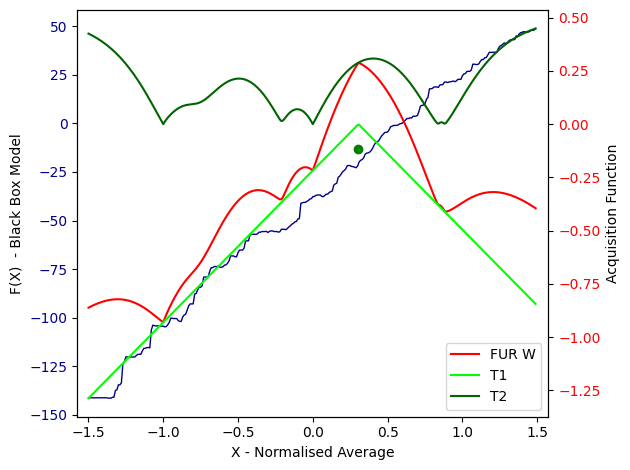

In [25]:
acq_data.plot_point(8)

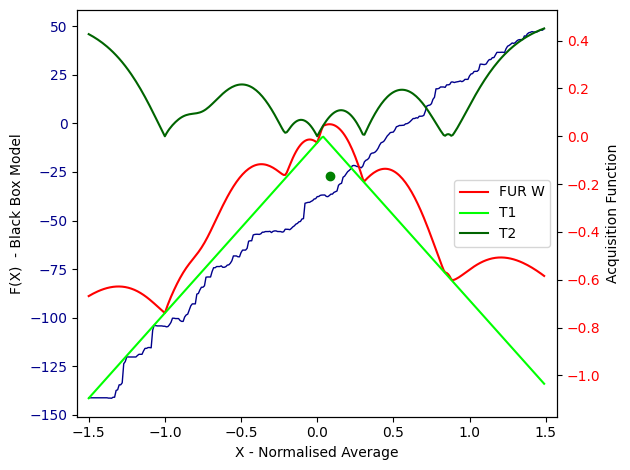

In [26]:
acq_data.plot_point(9)

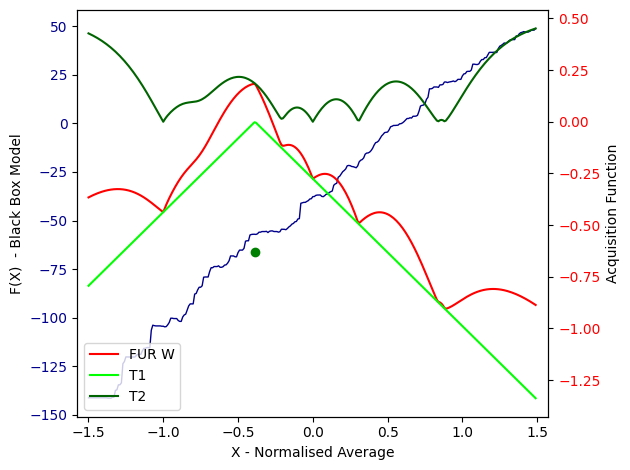

In [27]:
acq_data.plot_point(10)

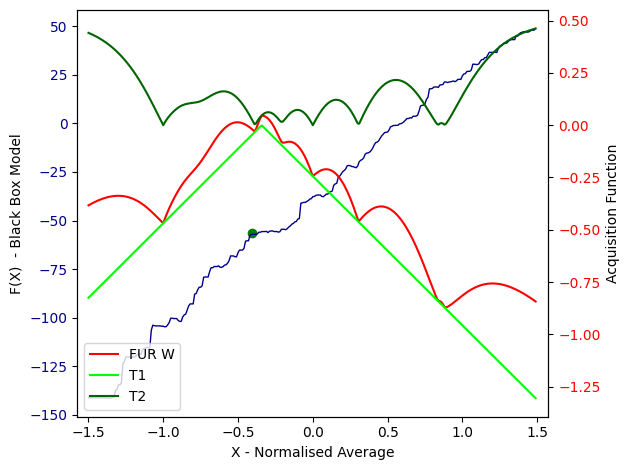

In [28]:
acq_data.plot_point(11)

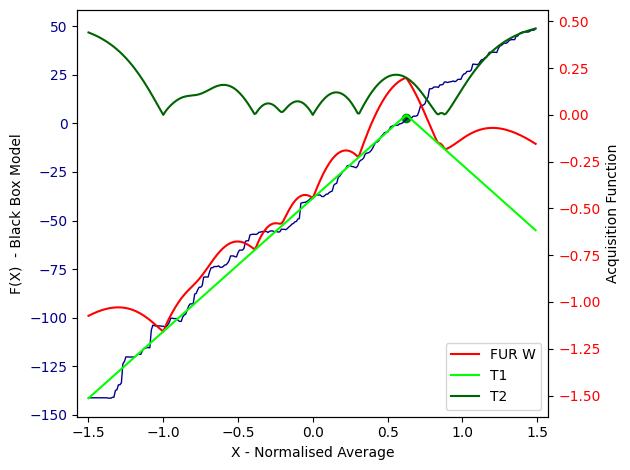

In [29]:
acq_data.plot_point(12)

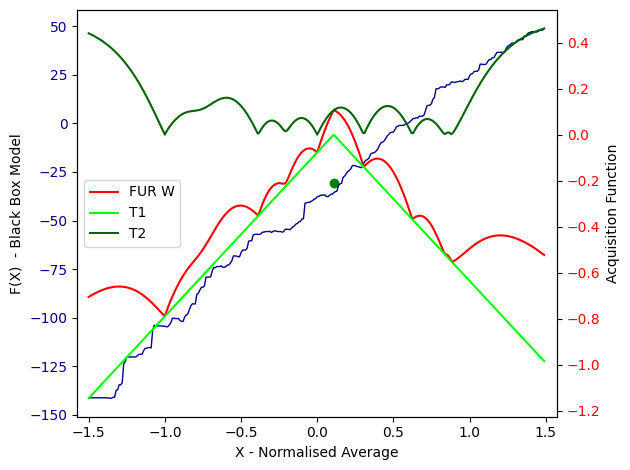

In [30]:
acq_data.plot_point(13)

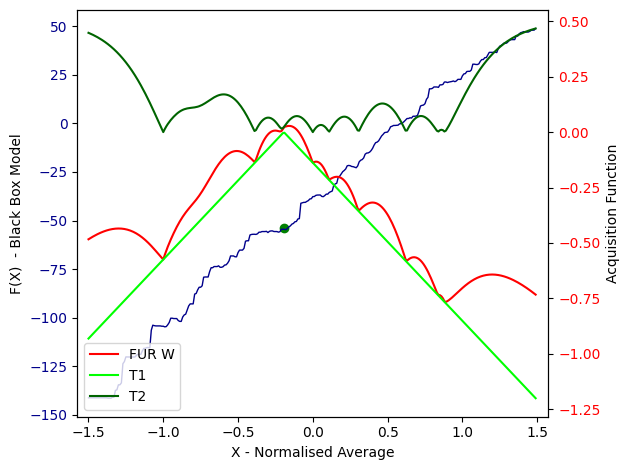

In [31]:
acq_data.plot_point(14)

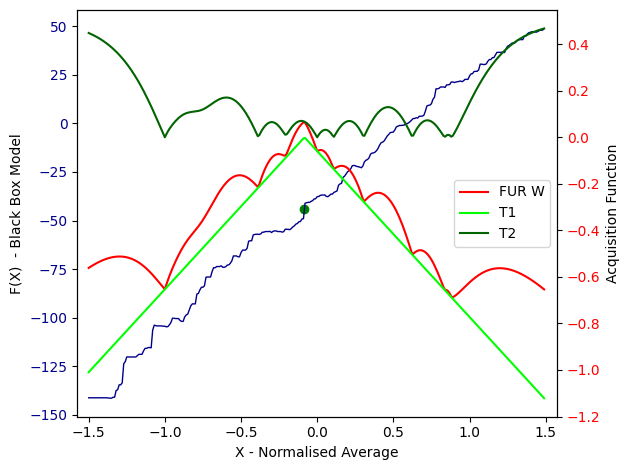

In [32]:
acq_data.plot_point(15)

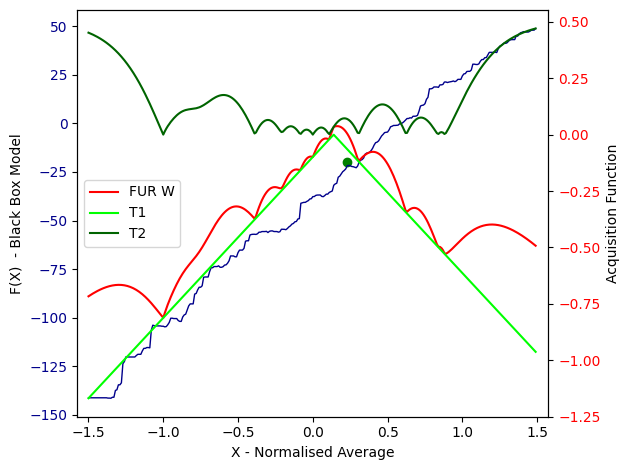

In [33]:
acq_data.plot_point(16)

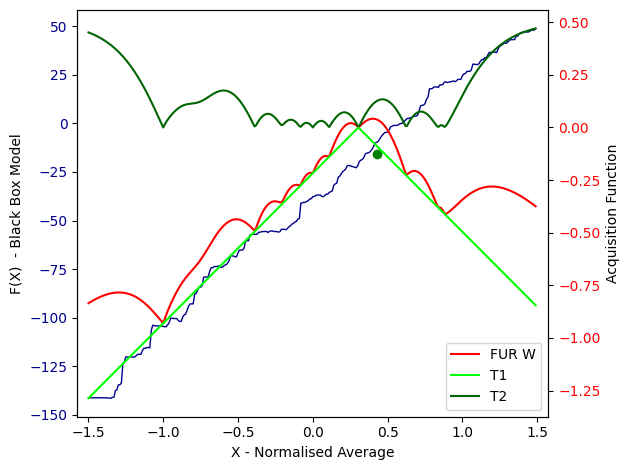

In [34]:
acq_data.plot_point(17)

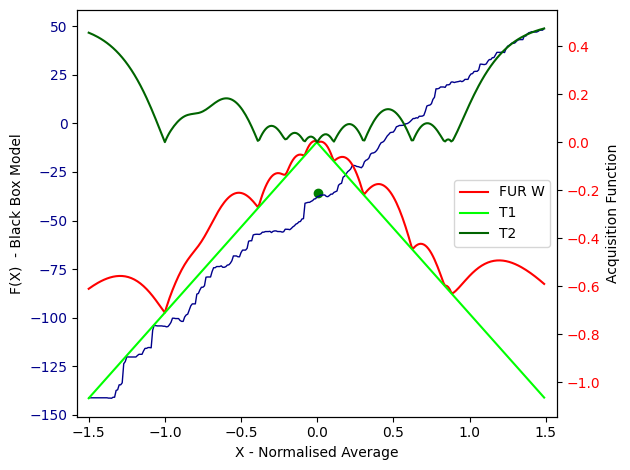

In [35]:
acq_data.plot_point(18)

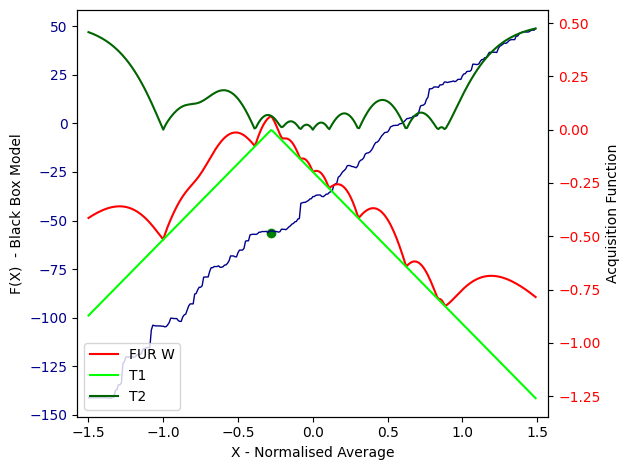

In [36]:
acq_data.plot_point(19)

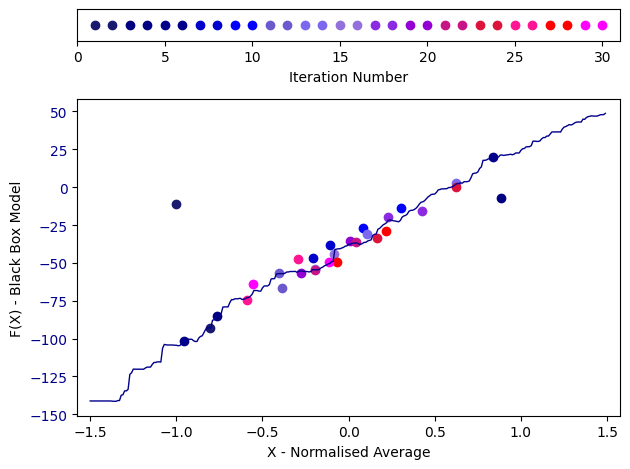

In [37]:
acq_data.plot_all()